# 07. PyTorch Experiment Tracking

https://www.learnpytorch.io/07_pytorch_experiment_tracking/

## Table of Contents

- [All Links in Document](#links)
- [Prepare Data and Model](#prep)
- [Training a Model](#trainmodel)
- [Using TensorBoard](#usetb)
- [TensorBoard Helper Function](#tbhelp)
- [Choosing Best Model](#choosebest)
- [Evaluation](#eval)

## All Links in Document <a name="links" />

- https://www.tensorflow.org/tensorboard/
- https://code.visualstudio.com/docs/datascience/pytorch-support#_tensorboard-integration

## PyTorch Experiment Tracking

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchmetrics import Accuracy
from torchinfo import summary
import os
from PIL import Image
from pathlib import Path
from typing import List, Tuple
import random

In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu117
0.14.1+cu117


So far, plenty of various models have been created, experimented with, and improved over multiple iterations. So far, keeping track of results was done by manually creating dictionaries. This is a rather simple and effective, but rookie approach. Such simple methods may quickly become unsustainable as models grow, or in scenarios where many models are run simultaneously.

The concept of experiment tracking is extremely important and integral to machine learning and deep learning as they are naturally experimental. As experiments and changes are tinkered with, it's necessary to keep track of everything that is going on.

<img src="images/07_experiment_tracking_examples.png" />

The above image illustrates various example of experiment tracking. As stated, it's possible to do it manually through various dictionaries and files, but there are more professional methods available too. This Notebook will focus on TensorBoard due to its widespread use and integration with PyTorch. It's free to use and will only require the installation of the `tensorboard` package. More information about TensorBoard can be found on the Tensorflow website: https://www.tensorflow.org/tensorboard/

The principles to be followed remain the same overall, but some new elements will be included:

- Acquire data
- Create datasets and dataloaders
- Load and customize a pretrained modele
- Train model and track results
- View results in TensorBoard
- Create a helper function to track experiments
- Set up a series of modelling experiments
- View modelling experiments' results in TensorBoard
- Load the best performing model and make predictions with it

*NOTE: Code is handwritten again for even more practice!*

## Prepare Data and Model <a name="prep" />

In [3]:
# Creating data paths
IMAGE_PATH = Path("data/PizzaSteakSushi")
TRAIN_DIR = Path(f"{IMAGE_PATH}/train")
TEST_DIR = Path(f"{IMAGE_PATH}/test")

As a pretrained model is to be used, and the creation of datasets requires the usage of the same transform as the pretrained model's transform, it's first necessary to load the pretrained model and its weights.

In [4]:
# Loading pretrained model and weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights)

In [5]:
# Loading the pretrained model's transforms
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [6]:
# Create datasets
train_data = datasets.ImageFolder(root=TRAIN_DIR, transform=auto_transforms)
test_data = datasets.ImageFolder(root=TEST_DIR, transform=auto_transforms)

In [7]:
# Create dataloaders and class names
train_dataloader = DataLoader(dataset=train_data, batch_size=32, num_workers=os.cpu_count(), shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, num_workers=os.cpu_count(), shuffle=False)
class_names = train_data.classes

In [8]:
# Freezing the model's base layers
for param in model.features.parameters():
    param.requires_grad = False

In [9]:
# Checking model's default classifier
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [10]:
# Updating model's default classifier to suit the custom problem
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
)

In [11]:
# Checking model's updated classifier
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [12]:
# Checking summary of the model
summary(model=model,
        input_size=[32, 3, 224, 224],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=19, 
        device="cpu")

Layer (type:depth-idx)                                  Input Shape         Output Shape        Param #             Trainable
EfficientNet                                            [32, 3, 224, 224]   [32, 3]             --                  Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]   [32, 1280, 7, 7]    --                  False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]   [32, 32, 112, 112]  --                  False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]   [32, 32, 112, 112]  (864)               False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]  [32, 32, 112, 112]  (64)                False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]  [32, 32, 112, 112]  --                  --
│    └─Sequential: 2-2                                  [32, 32, 112, 112]  [32, 16, 112, 112]  --                  False
│    │    └─MBConv: 3

The summary correctly shows how most of the params are non-trainable (as they were frozen earlier), and the output layer is correctly transformed to better suit the custom problem of the PizzaSteakSushi dataset.

## Training a Model <a name="trainmodel" />

In [13]:
# Creating loss function, optimizer, and metric
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
metric_fn = Accuracy(task="multiclass", num_classes=len(class_names))

Previously, this is where multiple lists and dictionaries would be created to keep track of results during the training and testing loops. However, this is where `SummaryWriter` from `torch.utils.tensorboard` can have a chance to shine. By default, the `SummaryWriter` saves various information about a model to a file set by its `log_dir` parameter. The default location for these logs is `runs/CURRENT_DATETIME_HOSTNAME`, where the `HOSTNAME` is the name of the computer. It's of course customizable where experiments are tracked.

The outputs of the `SummaryWriter()` are saved in TensorBoard format.

In [14]:
# Create a TensorBoard writer with all default settings
writer = SummaryWriter()

To make use of this writer, it's necessary to make several changes to the training and testing loops. To save loss and accuracy values, it's possible to use the `add_scalars(main_tag, tag_scalar_dict)` method of the writer where:

- `main_tag` (string) is the name for the scalars being tracked, e.g., "Accuracy"
- `tag_scalar_dict` (dict) is a dictionary of the values being tracked, e.g., `{"train_loss": 0.1234}`

This method is called `add_scalars()` as the loss and accuracy values are generally scalars (single values). Afterwards, it's necessary to call `writer.close()` to tell the writer to stop looking for values to track.

In [15]:
# Updated training and testing loop to accommodate SummaryWriter
torch.manual_seed(42)
NUM_EPOCHS = 5

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = 0, 0
    test_loss, test_acc = 0, 0
    
    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        y_logits = model(X)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
        loss = loss_fn(y_logits, y)
        train_loss += loss
        train_acc += metric_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    
    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            test_logits = model(X)
            test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
            test_loss += loss_fn(test_logits, y)
            test_acc += metric_fn(test_pred, y)
            
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    
    print(f"Epoch: {epoch}")
    print(f"Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.2f} | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}")

    writer.add_scalars(main_tag="Loss", global_step=epoch, tag_scalar_dict={"train_loss": train_loss, 
                                                                            "test_loss": test_loss})
    
    writer.add_scalars(main_tag="Accuracy", global_step=epoch, tag_scalar_dict={"train_acc": train_acc, 
                                                                                "test_acc": test_acc})
    
    writer.add_graph(model=model, input_to_model=torch.randn(32, 3, 224, 224))

writer.close()

Epoch: 0
Train Loss: 1.09522, Train Acc: 0.40 | Test Loss: 0.87943, Test Acc: 0.68
Epoch: 1
Train Loss: 0.90147, Train Acc: 0.68 | Test Loss: 0.79228, Test Acc: 0.80
Epoch: 2
Train Loss: 0.78005, Train Acc: 0.75 | Test Loss: 0.65130, Test Acc: 0.87
Epoch: 3
Train Loss: 0.69121, Train Acc: 0.75 | Test Loss: 0.61771, Test Acc: 0.87
Epoch: 4
Train Loss: 0.63938, Train Acc: 0.80 | Test Loss: 0.61572, Test Acc: 0.88


## Using TensorBoard <a name="usetb" />

The `SummaryWriter()` class stores the model's results in a directory called `runs/` in TensorBoard format by default. TensorBoard is a visualization program created by the TensorFlow team to view and inspect information about models and data. It's possible to view this TensorBoard in multiple environments:

- Visual Studio Code
- Jupyter and Colab Notebooks

For the Visual Studio Code method, press `SHIFT + CMD + P` to open the command palette and search for the command: `Python: Launch TensorBoard`. More information about using Visual Studio Code for this purpose can be found here: https://code.visualstudio.com/docs/datascience/pytorch-support#_tensorboard-integration

For the Jupyter and Colab Notebooks method, it's necessary that the `tensorboard` extension is installed. It's then possible to start an interactive TensorBoard session to view TensorBoard files in the `runs/` directory. This is done with the following code:

In [16]:
%load_ext tensorboard
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 19616), started 1 day, 22:13:42 ago. (Use '!kill 19616' to kill it.)

*NOTE: The interactive TensorBoard session will not be visible in GitHub after committing.*

## TensorBoard Helper Function <a name="tbhelp" />

The `SummaryWriter()` class logs various information to a directory specified by the `log_dir` parameter. Naturally, there is much more that's possible to customize. It's possible to track and customize almost everything, including:

- Experiment date/timestamp
- Experiment name
- Model name

In [17]:
%%writefile modular_scripts/create_writer.py
"""
Contains PyTorch code to instantiate a TensorBoard writer.
"""
import torch
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from pathlib import Path

def create_writer(
    experiment_name: str,
    model_name: str,
    extra: str=None
) -> torch.utils.tensorboard.writer.SummaryWriter():
    """
    Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.
    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.
    Timestamp is the current date in YYYY-MM-DD format.
    
    Args:
        experiment_name: Name of the experiment.
        model_name: Name of the model.
        extra: Anything extra to add to the directory.
        
    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.
    """   
    timestamp = datetime.now().strftime("%Y-%m-%d")
    
    if extra:
        log_dir = Path(f"runs/{timestamp}/{experiment_name}/{model_name}/{extra}")
    else:
        log_dir = Path(f"runs/{timestamp}/{experiment_name}/{model_name}")
        
    print(f"[INFO] Created SummaryWriter(), saving to: {log_dir}")
    return SummaryWriter(log_dir=log_dir)

Overwriting modular_scripts/create_writer.py


In [18]:
from modular_scripts import create_writer
#writer = create_writer.create_writer("PizzaSteakSushi", "effnetb0", "5epochs")

## Experimenting <a name="experiment" />

In [19]:
# Setting up models
weights_1 = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_1 = torchvision.models.efficientnet_b0(weights=weights_1)
transforms_1 = weights_1.transforms()

weights_2 = torchvision.models.EfficientNet_B2_Weights.DEFAULT
model_2 = torchvision.models.efficientnet_b2(weights=weights_2)
transforms_2 = weights_2.transforms()

In [20]:
torch.manual_seed(42)
TOTAL_EPOCHS = [5, 10]
DATASETS = ["PizzaSteakSushi", "PizzaSteakSushi20Percent"]
MODELS = {
    "effnetb0": [model_1, transforms_1, 0.2, 1280],
    "effnetb2": [model_2, transforms_2, 0.3, 1408]
}

for key, value in MODELS.items():
    for param in value[0].features.parameters():
        param.requires_grad = False
        
    for dataset in DATASETS:
        IMAGE_PATH = Path(f"data/{dataset}")
        TRAIN_DIR = Path(f"{IMAGE_PATH}/train")
        TEST_DIR = Path(f"{IMAGE_PATH}/test")
        
        train_data = datasets.ImageFolder(root=TRAIN_DIR, transform=value[1])
        test_data = datasets.ImageFolder(root=TEST_DIR, transform=value[1])
        
        train_dataloader = DataLoader(dataset=train_data, batch_size=32, num_workers=os.cpu_count(), shuffle=True)
        test_dataloader = DataLoader(dataset=test_data, batch_size=32, num_workers=os.cpu_count(), shuffle=False)
        class_names = train_data.classes
        
        value[0].classifier = nn.Sequential(
            nn.Dropout(p=value[2], inplace=True),
            nn.Linear(in_features=value[3], out_features=len(class_names), bias=True)
        )
        
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(params=value[0].parameters(), lr=0.001)
        metric_fn = Accuracy(task="multiclass", num_classes=len(class_names))
           
        for num_epochs in TOTAL_EPOCHS:
            writer = create_writer.create_writer(dataset, key, f"{num_epochs}")
            print(f"Model: {key}, Dataset: {dataset}, Epochs: {num_epochs}")
            for epoch in range(num_epochs):
                train_loss, train_acc = 0, 0
                test_loss, test_acc = 0, 0
                
                value[0].train()
                for batch, (X, y) in enumerate(train_dataloader):
                    y_logits = value[0](X)
                    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
                    loss = loss_fn(y_logits, y)
                    train_loss += loss
                    train_acc += metric_fn(y_pred, y)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                train_loss /= len(train_dataloader)
                train_acc /= len(train_dataloader)
                
                value[0].eval()
                with torch.inference_mode():
                    for batch, (X, y) in enumerate(test_dataloader):
                        test_logits = value[0](X)
                        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
                        test_loss += loss_fn(test_logits, y)
                        test_acc += metric_fn(test_pred, y)
                        
                    test_loss /= len(test_dataloader)
                    test_acc /= len(test_dataloader)
                    
                writer.add_scalars(main_tag="Loss", global_step=epoch, tag_scalar_dict={"train_loss": train_loss, 
                                                                                        "test_loss": test_loss})
    
                writer.add_scalars(main_tag="Accuracy", global_step=epoch, tag_scalar_dict={"train_acc": train_acc, 
                                                                                            "test_acc": test_acc})
    
                writer.add_graph(model=model, input_to_model=torch.randn(32, 3, value[1].crop_size[0], value[1].crop_size[0]))
                    
                print(f"Epoch: {epoch}")
                print(f"Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.2f} | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}")
            
            MODEL_PATH = "models"
            MODEL_SAVE_NAME = f"{MODEL_PATH}/07_{key}_{dataset}_{num_epochs}.pth"
            torch.save(obj=value[0].state_dict(), f=MODEL_SAVE_NAME)
            
            writer.close()

[INFO] Created SummaryWriter(), saving to: runs\2023-04-06\PizzaSteakSushi\effnetb0\5
Model: effnetb0, Dataset: PizzaSteakSushi, Epochs: 5
Epoch: 0
Train Loss: 1.05523, Train Acc: 0.48 | Test Loss: 0.87092, Test Acc: 0.68
Epoch: 1
Train Loss: 0.94314, Train Acc: 0.57 | Test Loss: 0.78695, Test Acc: 0.79
Epoch: 2
Train Loss: 0.78050, Train Acc: 0.74 | Test Loss: 0.69702, Test Acc: 0.84
Epoch: 3
Train Loss: 0.69991, Train Acc: 0.75 | Test Loss: 0.58291, Test Acc: 0.91
Epoch: 4
Train Loss: 0.61254, Train Acc: 0.88 | Test Loss: 0.56814, Test Acc: 0.93
[INFO] Created SummaryWriter(), saving to: runs\2023-04-06\PizzaSteakSushi\effnetb0\10
Model: effnetb0, Dataset: PizzaSteakSushi, Epochs: 10
Epoch: 0
Train Loss: 0.60886, Train Acc: 0.75 | Test Loss: 0.58287, Test Acc: 0.86
Epoch: 1
Train Loss: 0.58261, Train Acc: 0.79 | Test Loss: 0.50173, Test Acc: 0.85
Epoch: 2
Train Loss: 0.49214, Train Acc: 0.94 | Test Loss: 0.50431, Test Acc: 0.86
Epoch: 3
Train Loss: 0.47420, Train Acc: 0.93 | Test Los

*NOTE: If TensorBoard errors out by saying it cannot connect to localhost, use `del /q %TMP%\.tensorboard-info\*` in any command prompt, then run the TensorBoard code again.* 

In [21]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 19616), started 1 day, 23:46:51 ago. (Use '!kill 19616' to kill it.)

## Choosing Best Model <a name="choosebest" />

In [22]:
best_model_path = "models/07_effnetb0_PizzaSteakSushi20Percent_10.pth"

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
best_model = torchvision.models.efficientnet_b0(weights=weights)
for param in model.features.parameters():
    param.requires_grad = False 
    
best_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
)

best_model.load_state_dict(torch.load(best_model_path))   

<All keys matched successfully>

In [23]:
best_transforms = weights.transforms()
best_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

## Evaluation <a name="eval" />

In [24]:
# Making a prediction function
def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str],
    transform: torchvision.transforms
) -> None:
    
    img = Image.open(image_path)
    model.eval()
    with torch.inference_mode():
        transformed_img = transform(img).unsqueeze(dim=0)
        pred_logits = model(transformed_img)
        pred_probs = torch.softmax(pred_logits, dim=1)
        pred_label = torch.argmax(pred_probs, dim=1)
        
        plt.figure()
        plt.imshow(img)
        plt.title(f"Pred: {class_names[pred_label]} | Prob: {pred_probs.max():.3f}")
        plt.axis(False);

In [25]:
# Collecting 5 random custom image paths
img_count = 5
img_paths = list(Path(TEST_DIR).glob("*/*.jpg"))
img_sample = random.sample(img_paths, img_count)

In [26]:
img_sample

[WindowsPath('data/PizzaSteakSushi20Percent/test/steak/39461.jpg'),
 WindowsPath('data/PizzaSteakSushi20Percent/test/pizza/476421.jpg'),
 WindowsPath('data/PizzaSteakSushi20Percent/test/sushi/2378406.jpg'),
 WindowsPath('data/PizzaSteakSushi20Percent/test/steak/3173402.jpg'),
 WindowsPath('data/PizzaSteakSushi20Percent/test/steak/670345.jpg')]

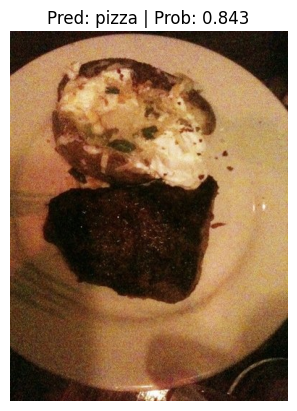

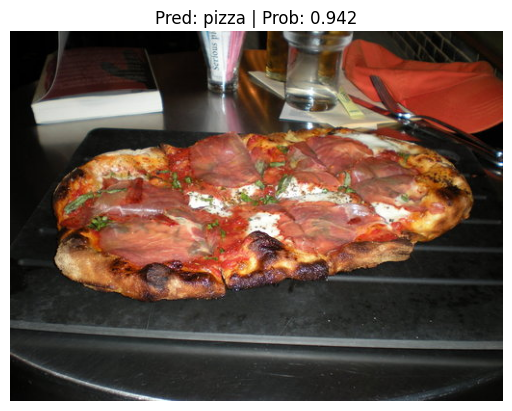

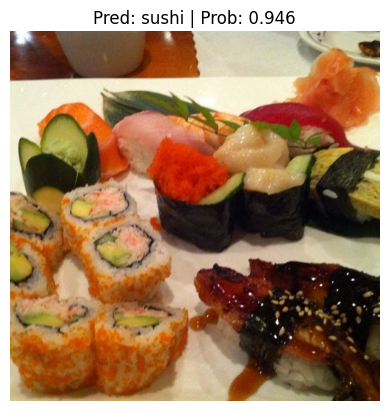

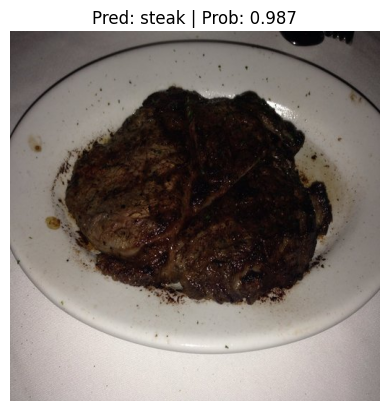

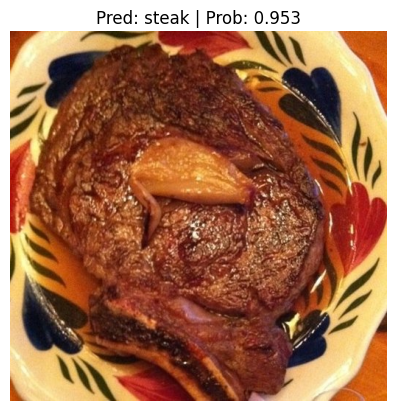

In [27]:
for i in img_sample:
    pred_and_plot_image(best_model, i, class_names, best_transforms)

Pred Class: pizza | Pred Prob: 0.988


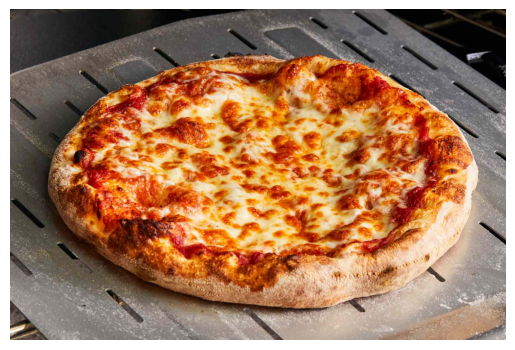

In [28]:
# Get an image of pizza/steak/sushi
custom_img = Image.open("images/04_pizza.jpg")
best_model.eval()
with torch.inference_mode():
    trns_img = best_transforms(custom_img).unsqueeze(0)
    pred_logit = best_model(trns_img)
    pred_prob = torch.softmax(pred_logit, dim=1)
    pred_label = torch.argmax(pred_prob, dim=1)
    
    print(f"Pred Class: {class_names[pred_label]} | Pred Prob: {pred_prob.max():.3f}")
    plt.figure()
    plt.imshow(custom_img)
    plt.axis(False);